# Control Experiment: Atoms Only

This control tests the same scalar prediction mechanism but **without message passing** and **without molecular context**. Each atom's scalar is predicted independently from its local features only.

In [17]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader

from src.mp_graph.featurizer import Featurizer
from src.mlp_regressor.mlp import AtomOnlyMLP
from src.mlp_regressor.training import MoleculeDataset, collate_molecules

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Data Loading

Load raw atom features (no MPNN processing).

In [18]:
# Load splits
DATA_DIR = Path('../data')
SPLITS_DIR = DATA_DIR / 'splits'

train_df = pd.read_csv(SPLITS_DIR / 'train.csv')
val_df = pd.read_csv(SPLITS_DIR / 'val.csv')
test_df = pd.read_csv(SPLITS_DIR / 'test.csv')

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

Train: 10051, Val: 1117, Test: 2793


In [19]:
def process_molecules_raw(df):
    """Process molecules using raw atom features (no MPNN)."""
    featurizer = Featurizer()
    
    X_atom_fps = []
    atom_contribs = []
    mol_indexs = []
    mol_data = []
    
    for mol_idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing'):
        smiles = str(row['smiles']).split('|')[0]
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        
        # Raw atom features (no message passing)
        atom_feats = featurizer.featurize_atoms(mol)
        contribs = np.array([x[0] for x in Crippen._GetAtomContribs(mol)])
        
        mol_info = {
            'mol_index': len(mol_data),
            'smiles': smiles,
            'exp_logp': row['exp_logp'],
            'rdkit_logp': row['rdkit_logp'],
            'mw': row['mw'],
            'num_atoms': mol.GetNumAtoms(),
            'atom_contribs': contribs
        }
        mol_data.append(mol_info)
        
        for atom_idx in range(mol.GetNumAtoms()):
            X_atom_fps.append(atom_feats[atom_idx])
            atom_contribs.append(contribs[atom_idx])
            mol_indexs.append(mol_info['mol_index'])
    
    return np.array(X_atom_fps), np.array(atom_contribs), np.array(mol_indexs), mol_data

In [20]:
# Process all splits
train_X, train_contribs, train_mol_idx, train_mol_data = process_molecules_raw(train_df)
val_X, val_contribs, val_mol_idx, val_mol_data = process_molecules_raw(val_df)
test_X, test_contribs, test_mol_idx, test_mol_data = process_molecules_raw(test_df)

print(f'Raw atom feature dim: {train_X.shape[1]}')
print(f'Train atoms: {len(train_X)}, Val atoms: {len(val_X)}, Test atoms: {len(test_X)}')

Processing: 100%|██████████| 2793/2793 [00:01<00:00, 1410.76it/s]


Raw atom feature dim: 40
Train atoms: 171947, Val atoms: 18740, Test atoms: 47584


In [21]:
# Create datasets and loaders
BATCH_SIZE = 32

train_indices = np.arange(len(train_mol_data))
val_indices = np.arange(len(val_mol_data))
test_indices = np.arange(len(test_mol_data))

train_dataset = MoleculeDataset(train_X, train_contribs, train_mol_idx, train_mol_data, train_indices)
val_dataset = MoleculeDataset(val_X, val_contribs, val_mol_idx, val_mol_data, val_indices)
test_dataset = MoleculeDataset(test_X, test_contribs, test_mol_idx, test_mol_data, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_molecules)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_molecules)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_molecules)

## Model

In [22]:
# Model configuration
INPUT_DIM = train_X.shape[1]  # Raw atom features (40)
HIDDEN_LAYERS = [40, 40, 32]
LEARNING_RATE = 0.001

model = AtomOnlyMLP(input_dim=INPUT_DIM, hidden_dims=HIDDEN_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

AtomOnlyMLP(
  (mlp): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=40, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 4,625


## Training

In [23]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training', leave=False):
        for mol in batch:
            atom_features = mol['atom_features'].to(device)
            atom_rdkit_score = mol['atom_rdkit_score'].to(device)
            exp_logp = mol['exp_logp'].to(device)
            
            optimizer.zero_grad()
            scalars = model(atom_features)
            pred_logp = (scalars * atom_rdkit_score).sum()
            loss = criterion(pred_logp.unsqueeze(0), exp_logp)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    return total_loss / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    preds, targets, baselines, mws, mol_indices = [], [], [], [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            for mol in batch:
                atom_features = mol['atom_features'].to(device)
                atom_rdkit_score = mol['atom_rdkit_score'].to(device)
                
                scalars = model(atom_features)
                pred_logp = (scalars * atom_rdkit_score).sum().item()
                
                preds.append(pred_logp)
                targets.append(mol['exp_logp'].item())
                baselines.append(mol['rdkit_logp'].item())
                mws.append(mol['mw'])
                mol_indices.append(mol['mol_index'])
    return np.array(preds), np.array(targets), np.array(baselines), np.array(mws), np.array(mol_indices)

In [24]:
# Training loop
NUM_EPOCHS = 50
PATIENCE = 10

best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_preds, val_targets, _, _, _ = evaluate(model, val_loader, device)
    val_loss = mean_squared_error(val_targets, val_preds)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'atoms_only_best.pt')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val MSE = {val_loss:.4f}')
    
    if patience_counter >= PATIENCE:
        print(f'Early stopping at epoch {epoch+1}')
        break

model.load_state_dict(torch.load('atoms_only_best.pt'))

Epoch 5: Train Loss = 1.1042, Val MSE = 0.9618


Epoch 10: Train Loss = 1.0749, Val MSE = 0.9985


Epoch 15: Train Loss = 1.0650, Val MSE = 0.9559


Early stopping at epoch 16


<All keys matched successfully>

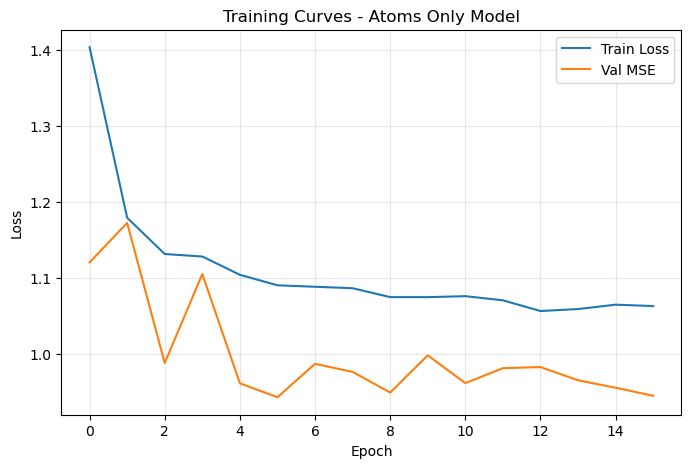

In [25]:
# Training curves
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Val MSE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Curves - Atoms Only Model')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Evaluation

In [26]:
# Evaluate on test set
test_preds, test_targets, test_baselines, test_mws, test_mol_indices = evaluate(model, test_loader, device)

rmse_baseline = np.sqrt(mean_squared_error(test_targets, test_baselines))
mae_baseline = mean_absolute_error(test_targets, test_baselines)
rmse_model = np.sqrt(mean_squared_error(test_targets, test_preds))
mae_model = mean_absolute_error(test_targets, test_preds)

print('Test Set Performance')
print('=' * 50)
print(f'{"Metric":<20} | {"Wildman-Crippen":<15} | {"Atoms Only":<15}')
print('-' * 50)
print(f'{"RMSE":<20} | {rmse_baseline:<15.4f} | {rmse_model:<15.4f}')
print(f'{"MAE":<20} | {mae_baseline:<15.4f} | {mae_model:<15.4f}')

Test Set Performance
Metric               | Wildman-Crippen | Atoms Only     
--------------------------------------------------
RMSE                 | 2.0893          | 1.0058         
MAE                  | 1.7294          | 0.7705         


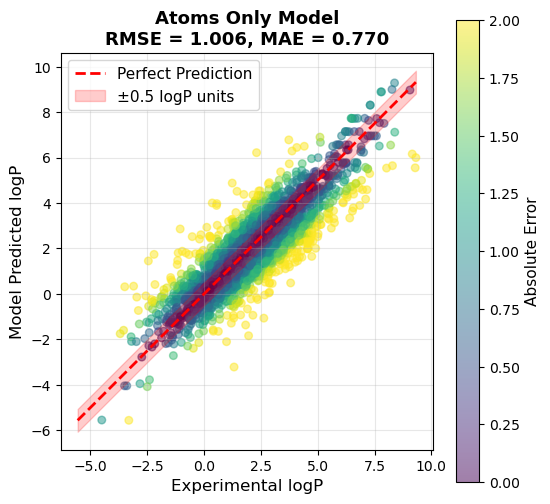

In [27]:
# Scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

scatter = ax.scatter(test_targets, test_preds, alpha=0.5, s=30, 
                     c=np.abs(test_targets - test_preds), cmap='viridis', vmin=0, vmax=2)

min_val = min(test_targets.min(), test_preds.min())
max_val = max(test_targets.max(), test_preds.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax.fill_between([min_val, max_val], [min_val - 0.5, max_val - 0.5], 
                [min_val + 0.5, max_val + 0.5], alpha=0.2, color='red', label='±0.5 logP units')

ax.set_xlabel('Experimental logP', fontsize=12)
ax.set_ylabel('Model Predicted logP', fontsize=12)
ax.set_title(f'Atoms Only Model\nRMSE = {rmse_model:.3f}, MAE = {mae_model:.3f}', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=11)
plt.show()

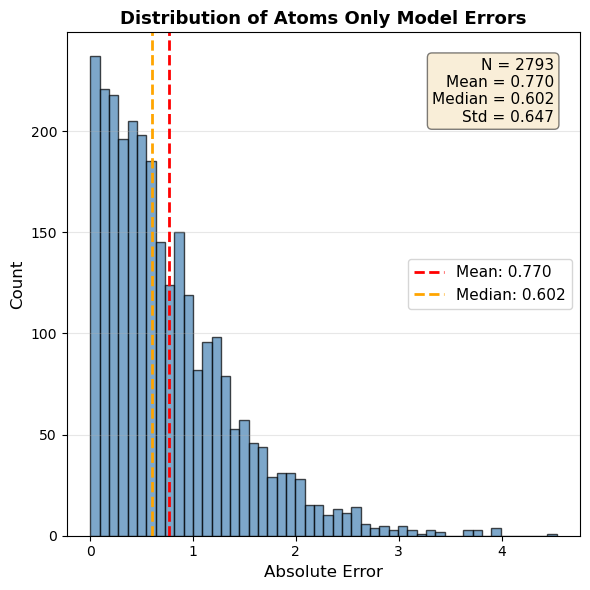

In [28]:
# Error histogram
model_abs_errors = np.abs(test_preds - test_targets)

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(model_abs_errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')

mean_error = np.mean(model_abs_errors)
median_error = np.median(model_abs_errors)
ax.axvline(mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_error:.3f}')
ax.axvline(median_error, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_error:.3f}')

ax.set_xlabel('Absolute Error', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Atoms Only Model Errors', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

stats_text = f'N = {len(model_abs_errors)}\n'
stats_text += f'Mean = {mean_error:.3f}\n'
stats_text += f'Median = {median_error:.3f}\n'
stats_text += f'Std = {np.std(model_abs_errors):.3f}'
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Summary

The atoms-only model predicts scalars using only local atom features, without:
- Message passing (no neighbor information)
- Molecular context (no global pooling)

Compare RMSE/MAE with the full model to quantify the contribution of these components.